In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
%matplotlib inline
from FNO2D import FNO2d
from FourierGridMethod import Fourier_Grid,normalize_wfn,side_wp
from simulation import potential,alpha, random_perturbation, chirped_pulse, complete_simulation
from bayesian import likelihood
import pickle
import os
cwd = os.getcwd()

In [2]:
# setting random for the nosie
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

modelname = cwd+'/model/data-gaussian-pulse-10000.pt'
model = torch.load(modelname)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
def plot_intensity(y_grid, params):
    elec_pulse = chirped_pulse(y_grid, params['A0'], params['t0'], params['sig'], params['f0'], params['beta'], np.pi)
    c = 299792458
    e0 = 8.85418782e-12
    E = 5.14220674763e9
    intensity = 0.5*e0*c*(E*elec_pulse)**2
    plt.close()
    plt.title('Laser pulse intensity versus time')
    plt.xlabel('time (ps)')
    plt.ylabel('intensity TW/cm$^{-2}$')
    plt.plot(y_grid, intensity/1e12)
    plt.savefig(cwd+'/picture/intensity-FNO.png')
    plt.show()

# parameters

In [4]:
n_iterations = 10000
burn_in = 1000

param_1 = 0.019527390846138085 # initial value for the first field parameter A0
param_2 = 0.07998492062926205 # initial value for the second field parameter sig
param_3 = 1.457428641843488 #initial value of third parameter 
params = [param_1, param_2,param_3] # current parameter values

# Define the range bounds for the parameters
param_1_bounds = [0.0100, 0.0238] #A0 (au)
param_2_bounds = [0.05, 0.10] #f0
param_3_bounds = [1.00, 3.00] #sigma

#print(*stats.norm.fit(param_1_bounds),np.std(param_1_bounds),np.mean(param_1_bounds))
#mu1,std1=stats.norm.fit(param_1_bounds)
# Define the prior distribution for the field parameters
param_1_prior = stats.truncnorm((param_1_bounds[0] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                (param_1_bounds[1] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                loc=np.mean(param_1_bounds),
                                scale=np.std(param_1_bounds))
param_2_prior = stats.truncnorm((param_2_bounds[0] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                (param_2_bounds[1] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                loc=np.mean(param_2_bounds),
                                scale=np.std(param_2_bounds))
param_3_prior = stats.truncnorm((param_3_bounds[0] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                (param_3_bounds[1] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                loc=np.mean(param_3_bounds),
                                scale=np.std(param_3_bounds))

# Initialize the acceptance counter
accept_counter = 0
choose_score = 0
# Initialize the parameter trace
param_trace = np.zeros((n_iterations, 3))
score_trace = np.zeros((n_iterations))

# Get the starting and target state by FourierGridMethod

In [5]:
#Setting variables for the simulation
#the hamiltonian for the system is 

# Define the x and y coordinates of the grid

x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = 128, 300

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
y_grid = np.linspace(y_min, y_max, y_size)

#Define meshgrid terms for 3D plots and making perturbations
x_dim, t_dim = np.meshgrid(x_grid, y_grid)

nstates=20
#Scale for unit conversion to au
ev_scale=1/(27.211*1e3)
IBr=8911925
IF=1864705
Irel=(IBr*IF)/(IBr+IF)    

#Generate the double well potential
V_pot=potential(x_grid,y_grid)
#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9

#Generate the n_v term and plot it. This term is in mev
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)

V_vib_meV=V_pot+phi_perturb
V_vib_au=ev_scale*(V_pot+phi_perturb)

E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_au[0])
test_wf=normalize_wfn(psi0,x_grid,5)
    
psi_start=side_wp(psi0,-1)
psi_start = psi_start
psi_ref=psi_start[::-1]
alpha_1=np.vectorize(alpha)(x_grid)

pot_params={'psi_start':torch.from_numpy(psi_start**2),'psi_ref':torch.from_numpy((psi_ref**2).copy()),'V_vib':V_vib_au,'alpha':alpha_1, 'I_rel': Irel}


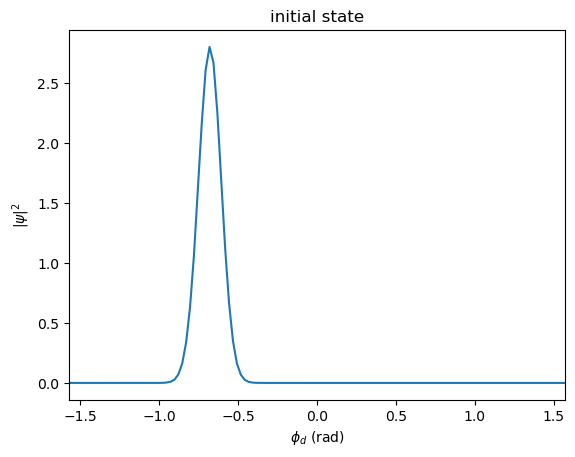

In [6]:
#checking the starting state
plt.close()
plt.plot(x_grid, psi_start)
plt.title('initial state')
plt.ylabel('$|\psi|^2$')
plt.xlabel('$\phi_d$ (rad)')
plt.xlim([-3.14/2,3.14/2])
plt.show()

# MCMC on FNO

In [7]:
nx = len(x_grid)
nt = len(y_grid[::2])
gridx = torch.from_numpy(x_grid).reshape(1, 1, nx)
gridy = torch.from_numpy(y_grid[::2]).reshape(1, nt, 1)
x1=gridx.repeat([1, nt, 1])
t1=gridy.repeat([1, 1, nx])

In [8]:
# Define the acceptance function
def acceptance(model, current_params, prop_params,x1,t1,param_1_prior,param_2_prior,param_3_prior,pot_params):
    def predict(model, x, psi_ref):
        model.eval()
        with torch.no_grad():
            x = x.to(device).float()
            out = model(x).view(1,1,150,x_size)
            psit = out[0][0][-1]
            mse = torch.nn.functional.mse_loss(psi_ref,psit.cpu())
            if mse < 0:
                mse = 1
            curr_score = 1 - mse
        return curr_score
    t0=0.0
    beta = 0.1
    
    A0_prop = prop_params[0]    
    f0_prop = prop_params[1]
    sig_prop = prop_params[2]
    A0_curr = current_params[0]
    f0_curr = current_params[1]
    sig_curr = current_params[2]
    
    psi_start=pot_params.get('psi_start',1)
    psi_ref=pot_params.get('psi_ref',2)
    V_vib=pot_params.get('V_vib',3)
    alpha_1=pot_params.get('alpha',4)
    phi = np.pi
    
    elec_f_curr = chirped_pulse(t_dim, A0_curr, t0, sig_curr, f0_curr, beta, phi)
    elec_f_prop = chirped_pulse(t_dim, A0_prop, t0, sig_prop, f0_prop, beta, phi)
    V_curr = torch.from_numpy((V_vib-0.25*(elec_f_curr**2)*(alpha_1))*100000)
    V_curr = V_curr[::2,:]
    V_curr = V_curr.repeat([1,1,1])
    V_prop = torch.from_numpy((V_vib-0.25*(elec_f_prop**2)*(alpha_1))*100000)
    V_prop = V_prop[::2,:]
    V_prop = V_prop.repeat([1,1,1])
    
    psi_start = psi_start.reshape(1, 1, nx)
    psi_start = psi_start.repeat([1, nt,1])
    
    curr_x = torch.stack([V_curr, psi_start, t1, x1], dim=1)
    prop_x = torch.stack([V_prop, psi_start, t1, x1], dim=1)
    
    curr_score=predict(model, curr_x, psi_ref)
    prop_score=predict(model, prop_x, psi_ref)
    
    curr_likelihood = likelihood(curr_score)
    prop_likelihood = likelihood(prop_score)
    
    prior_current = np.prod([param_1_prior.pdf(current_params[0]), param_2_prior.pdf(current_params[1]), param_3_prior.pdf(current_params[2])])
    prior_proposed = np.prod([param_1_prior.pdf(prop_params[0]), param_2_prior.pdf(prop_params[1]), param_3_prior.pdf(prop_params[2])])
    
    return min(1, (prop_likelihood * prior_proposed) / (curr_likelihood * prior_current)), prop_score, curr_score

In [9]:
#param_1 = 0.019927467186978617 # initial value for the first field parameter A0
#param_2 = 0.0948961733916297 # initial value for the second field parameter sig
#param_3 = 1.5225027541551555 #initial value of third parameter 
#params = [param_1, param_2,param_3] # current parameter values

param_1 = 0.019527390846138085 # initial value for the first field parameter A0
param_2 = 0.07998492062926205 # initial value for the second field parameter sig
param_3 = 1.457428641843488 #initial value of third parameter 
params = [param_1, param_2,param_3] # current parameter values

In [10]:
%%time
print('start MCMC...')

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record() 

for i in range(n_iterations):
    proposed_params = prior(param_1_prior,param_2_prior,param_3_prior)
    if i%1000 ==0 and i != 0:
        print("Running iterations: ", i, ";     current score (mse): ", choose_score.item())
    acceptance_prob,prop_score,curr_score = acceptance(model, params, proposed_params,x1,t1,param_1_prior,param_2_prior,param_3_prior,pot_params)
    
    # Accept or reject the proposal
    if np.random.uniform() < acceptance_prob:
        params = proposed_params # accept the proposal
        choose_score=prop_score
        accept_counter += 1
    else:
        params = params # reject the proposal
        choose_score=curr_score
    
    # Record the current parameter values
    param_trace[i,:] = params
    score_trace[i]=choose_score

end.record() 
torch.cuda.synchronize()

print('Done!')
print()
print('total running time oer iternations (GPU): ', start.elapsed_time(end)/n_iterations, 'ms/iteration')

start MCMC...
Running iterations:  1000 ;     current score (mse):  0.9539075937734302
Running iterations:  2000 ;     current score (mse):  0.9727967607957108
Running iterations:  3000 ;     current score (mse):  0.9783953435417245
Running iterations:  4000 ;     current score (mse):  0.9130302505474566
Running iterations:  5000 ;     current score (mse):  0.935275952782266
Running iterations:  6000 ;     current score (mse):  0.8236148632053091
Running iterations:  7000 ;     current score (mse):  0.9175147087942048
Running iterations:  8000 ;     current score (mse):  0.7281371862583653
Running iterations:  9000 ;     current score (mse):  0.9715407151719206
Done!

total running time oer iternations (GPU):  36.252634375 ms/iteration
CPU times: user 6min 1s, sys: 1.1 s, total: 6min 2s
Wall time: 6min 2s


# Evaluation

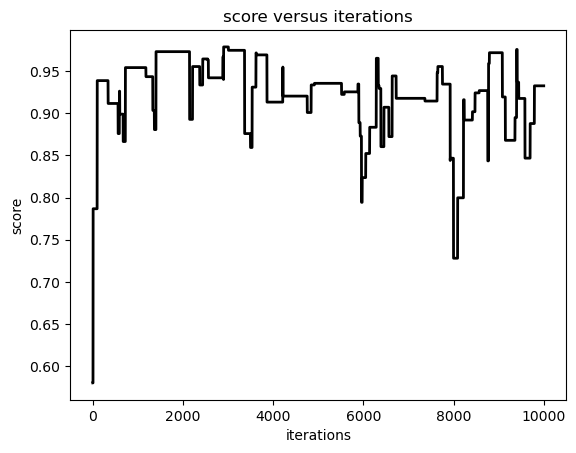

In [11]:
plt.close()
x=np.arange(0,n_iterations)
plt.plot(x, score_trace, ls="-", c="k", lw=2, label="$score$")
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('score versus iterations')
plt.savefig(cwd+'/picture/MCMC-FNO.png')

plt.show()

In [12]:
print('Highest score: ', max(score_trace))

Highest score:  0.9783953435417245


In [13]:
max_param = param_trace[np.argmax(score_trace)]
max_param = {'sig':max_param[2],'t0':0,'beta':0.1,'A0':max_param[0],'f0':max_param[1]}
print('Max score params: ', max_param)

Max score params:  {'sig': 1.4917496543158486, 't0': 0, 'beta': 0.1, 'A0': 0.018581409975267565, 'f0': 0.06512969791688951}


In [14]:
pot_params={'psi_start':psi_start,'psi_ref':psi_ref.copy(),'V_vib':V_vib_au,'alpha':alpha_1, 'I_rel': Irel}


overlap score:  0.46538850514760005
mse score:  tensor(0.9252, dtype=torch.float64)


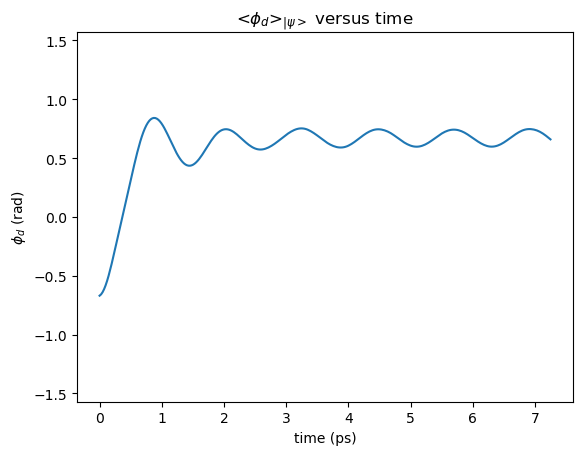

In [15]:
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,max_param, timestep=1000, MCMC=False)
print('overlap score: ', complete_simulation(x_grid,y_grid,pot_params,max_param, timestep=1000, MCMC=True))
print('mse score: ', complete_simulation(x_grid,y_grid,pot_params,max_param, timestep=1000, MCMC=True, overlap=False))

all_expect_pos = np.zeros(300)
Prob_den = D
dx = (x_max-x_min)/128
for i in range(300):
    Expect_pos = 0
    for j, x in enumerate(x_grid):
        expected = x*(Prob_den[i][j])*dx
        Expect_pos += expected
    all_expect_pos[i] = Expect_pos

plt.close()
plt.plot(y_grid, all_expect_pos)
plt.title('<$\phi_d$>$_{|\psi>}$ versus time')
plt.xlabel('time (ps)')
plt.ylim([x_min, x_max])
plt.ylabel('$\phi_d$ (rad)')
plt.savefig(cwd+'/picture/MCMC-FNO-max-expected.png')
plt.show()

In [18]:
# Define the thinning factor
thin_factor = 1000
burn_in = 2000
#remove the burn in samples
tmp=param_trace[burn_in::]
# Thin the parameter trace
thinned_trace = tmp[::thin_factor]

kde = stats.gaussian_kde(thinned_trace.T)

x_range = np.linspace(0.01, 0.0238, 1000)
y_range = np.linspace(0.00, 0.15, 1000)
p_range = np.linspace(1.00, 3.00, 1000)

# Evaluate the posterior distribution on the range of values
xx, yy, pp = np.meshgrid(x_range, y_range, p_range)
pos = np.vstack([xx.ravel(), yy.ravel(), pp.ravel()])
z = np.reshape(kde(pos).T, xx.shape)

# Find the maximum of the posterior distribution
max_idx = np.argmax(z)
max_x = pos[0][max_idx]
max_y = pos[1][max_idx]
max_pp = pos[2][max_idx]
max_z = z.ravel()[max_idx]

MCMC_params = {'sig':max_pp,'t0':0,'beta':0.1,'A0':max_x,'f0':max_y}
print('MCMC parmas: ', MCMC_params)

MCMC parmas:  {'sig': 1.7967967967967968, 't0': 0, 'beta': 0.1, 'A0': 0.017721921921921922, 'f0': 0.06456456456456457}


overlap score:  0.7828035431057666
mse score:  tensor(0.8516, dtype=torch.float64)


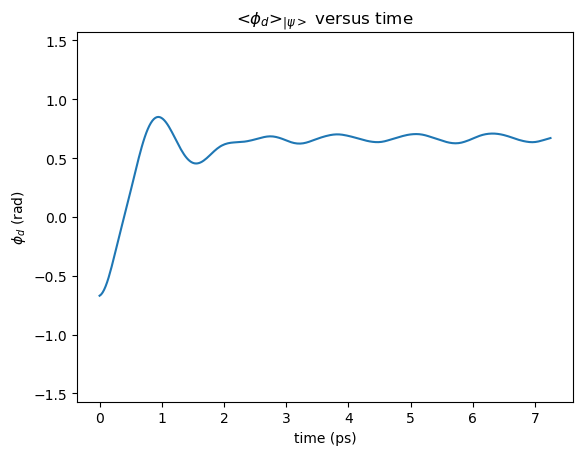

In [19]:
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,MCMC_params, timestep=1000, MCMC=False)
print('overlap score: ', complete_simulation(x_grid,y_grid,pot_params,MCMC_params, timestep=1000, MCMC=True))
print('mse score: ', complete_simulation(x_grid,y_grid,pot_params,MCMC_params, timestep=1000, MCMC=True, overlap=False))

all_expect_pos_sp = np.zeros(300)
Prob_den = D
dx = (x_max-x_min)/128
for i in range(300):
    Expect_pos = 0
    for j, x in enumerate(x_grid):
        expected = x*(Prob_den[i][j])*dx
        Expect_pos += expected
    all_expect_pos_sp[i] = Expect_pos

plt.close()
plt.plot(y_grid, all_expect_pos_sp)
plt.title('<$\phi_d$>$_{|\psi>}$ versus time')
plt.xlabel('time (ps)')
plt.ylim([x_min, x_max])
plt.ylabel('$\phi_d$ (rad)')
plt.savefig(cwd+'/picture/MCMC-FNO-MCMC-expected.png')
plt.show()

In [21]:
MCMC_params = {'sig':max_pp,'t0':0,'beta':0.1,'A0':max_x,'f0':max_y}
A0 = MCMC_params['A0']
t0 = MCMC_params['t0']
f0 = MCMC_params['f0']
beta= MCMC_params['beta']
sig = MCMC_params['sig']
phi = np.pi
V_vib = pot_params['V_vib']

elec_f = chirped_pulse(t_dim, A0, t0, sig, f0, beta, phi)
V_curr = torch.from_numpy((V_vib-0.25*(elec_f**2)*(alpha_1))*100000)
V_curr = V_curr[::2,:]
V_curr = V_curr.repeat([1,1,1])

psi_start = pot_params['psi_start']
psi_start = psi_start.reshape(1, 1, 128)
psi_start = torch.from_numpy(psi_start)
psi_start = psi_start.repeat([1, 150, 1])
    
x = torch.stack([V_curr, psi_start, t1, x1], dim=1)
with torch.no_grad():
    x = x.to(device).float()
    out = model(x).view(1,1,150,x_size)


In [24]:
MCMC_result = {'x_min': x_min, 'x_max': x_max, 'x_grid': x_grid, 'D': D[::2], 'out': out[0][0].cpu(), 'V': V_tot_au}

In [27]:
with open(cwd+'/result/MCMC-result.pickle', 'wb') as handle:
    pickle.dump(MCMC_result, handle, protocol=pickle.HIGHEST_PROTOCOL)